Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [2]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
# Defining the path for train and test images
from pathlib import Path
## Todo: Update the paths of the train and test dataset

data_dir_train = "/content/drive/MyDrive/Colab_Notebooks/SkinCancer_ISIC_Data/Train"
data_dir_test = "/content/drive/MyDrive/Colab_Notebooks/SkinCancer_ISIC_Data/Test"

In [5]:
os.listdir(data_dir_train)

['melanoma',
 'seborrheic keratosis',
 'actinic keratosis',
 'squamous cell carcinoma',
 'dermatofibroma',
 'vascular lesion',
 'nevus',
 'pigmented benign keratosis',
 'basal cell carcinoma']

In [6]:
os.listdir(data_dir_test)

['vascular lesion',
 'nevus',
 'actinic keratosis',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'squamous cell carcinoma']

In [7]:
import glob
image_count_train = len(glob.glob(data_dir_train + "/**/*.jpg"))
print(image_count_train)
#image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
#print(image_count_train)
image_count_test = len(glob.glob(data_dir_test + "/**/*.jpg"))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [24]:
batch_size = 32
img_height = 180
img_width = 180

In [9]:
!python --version

Python 3.10.12


In [10]:
!pip install tensorflow_datasets

In [11]:
from tensorflow.keras.utils import image_dataset_from_directory

Use 80% of the images for training, and 20% for validation.

In [25]:
# @title Training DataSet
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
#train_ds = ##todo
#data_train =
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  validation_split=0.2,
  subset= 'training')



Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [14]:
# @title Visualize distribution of classes in the training dataset.
def class_distribution_count(directory):

    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))

    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]

    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,melanoma,438
1,seborrheic keratosis,77
2,actinic keratosis,114
3,squamous cell carcinoma,181
4,dermatofibroma,95
5,vascular lesion,139
6,nevus,357
7,pigmented benign keratosis,462
8,basal cell carcinoma,376


In [26]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds =  tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  validation_split=0.2,
  subset= 'validation'
)


Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [16]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

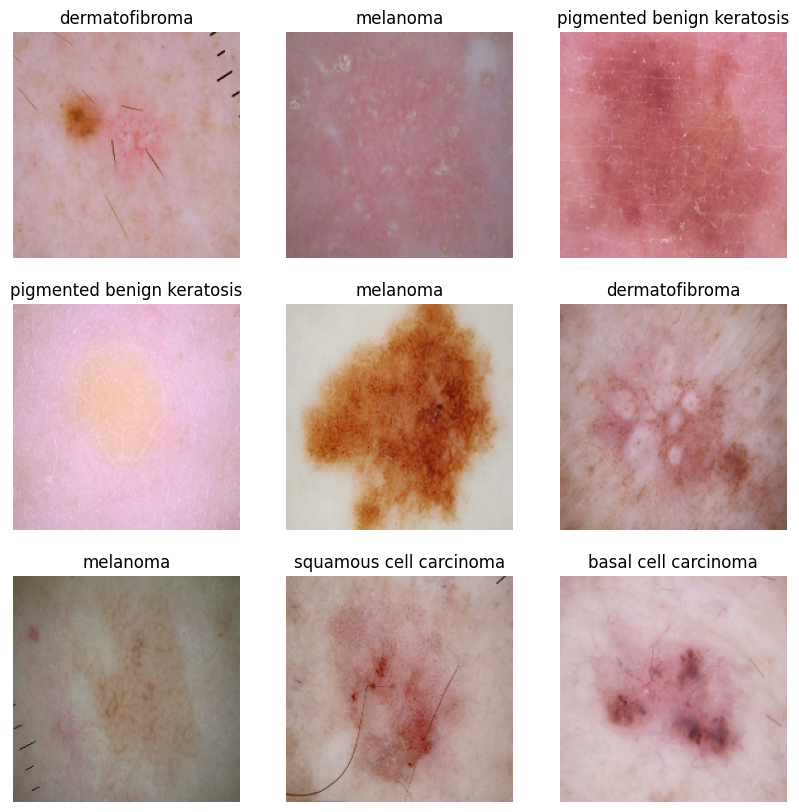

In [17]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [27]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [19]:
input_shape = (img_height,img_width,3)

model = Sequential()    #Sequential allows you to create models layer-by-layer

#First Convulation Layer
model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=input_shape))
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

model.add(layers.Flatten())   #Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.

#Dense Layer
model.add(layers.Dense(512,activation='relu'))

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

In [20]:
len(class_names)


9

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [28]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [29]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       7

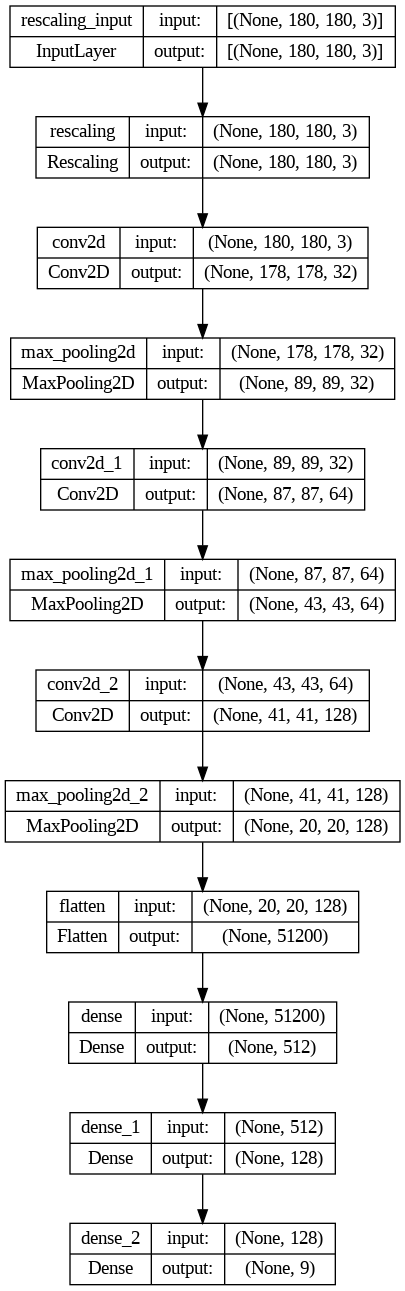

In [30]:
from tensorflow.keras.utils import plot_model
plot_model(model,to_file='model_plot.png',show_shapes=True, show_layer_names=True)

### Train the model

In [31]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 21s 42ms/step - loss: 1.9127 - accuracy: 0.2846 - val_loss: 1.6986 - val_accuracy: 0.3937
Epoch 2/20
56/56 [==============================] - 2s 41ms/step - loss: 1.6081 - accuracy: 0.4280 - val_loss: 1.6704 - val_accuracy: 0.4430
Epoch 3/20
56/56 [==============================] - 2s 42ms/step - loss: 1.4441 - accuracy: 0.4888 - val_loss: 1.3800 - val_accuracy: 0.5056
Epoch 4/20
56/56 [==============================] - 2s 40ms/step - loss: 1.3973 - accuracy: 0.4911 - val_loss: 1.4808 - val_accuracy: 0.4653
Epoch 5/20
56/56 [==============================] - 2s 40ms/step - loss: 1.3356 - accuracy: 0.5246 - val_loss: 1.4406 - val_accuracy: 0.5257
Epoch 6/20
56/56 [==============================] - 2s 40ms/step - loss: 1.1854 - accuracy: 0.5809 - val_loss: 1.5183 - val_accuracy: 0.5034
Epoch 7/20
56/56 [==============================] - 2s 40ms/step - loss: 1.1308 - accuracy: 0.5977 - val_loss: 1.4073 - val_accuracy: 0.5391
Epoch 8/20
5

### Visualizing training results

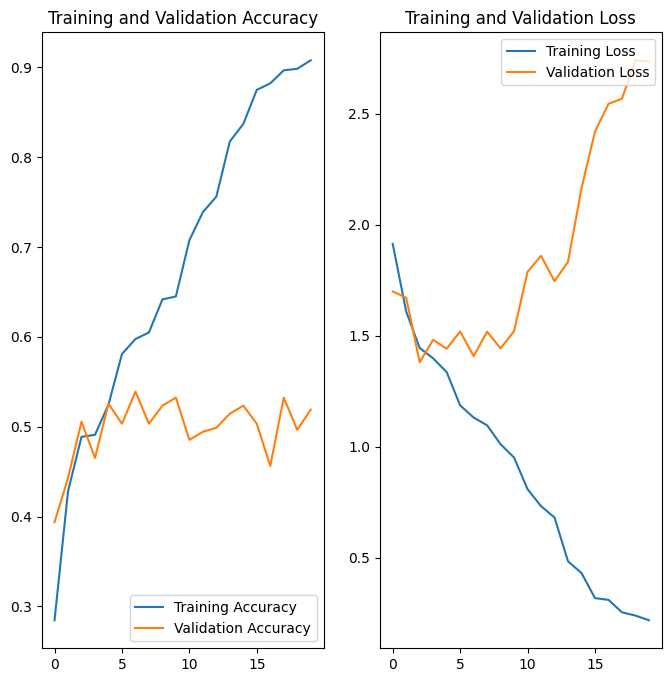

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

In [33]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
#As the training accuracy(92.35%)  is higher than validation accuracy(53.47%), it is an indication of overfitting. It means model is verfitting to the traing data.
# Your code goes here
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define data augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


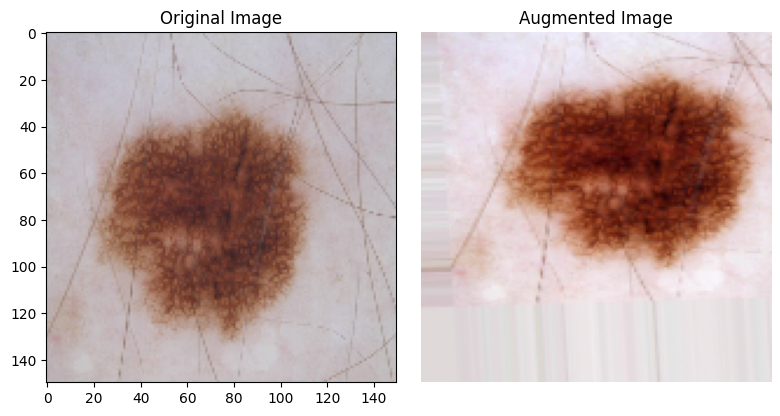

In [34]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
# Load a sample training image
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
img_path= "/content/drive/MyDrive/Colab_Notebooks/SkinCancer_ISIC_Data/Train/nevus/ISIC_0000019.jpg"
img = image.load_img(img_path, target_size=(150, 150))  # Adjust target size as needed
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original Image')

# Apply augmentation transformations
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.subplot(1, 2, 2)
    plt.imshow(image.array_to_img(batch[0]))
    plt.title('Augmented Image')
    plt.axis('off')
    i += 1
    if i >= 1:  # Number of augmentation instances to generate
        break  # Break the loop to prevent infinite generation

plt.tight_layout()
plt.show()

### Todo:
### Create the model, compile and train the model


In [35]:
#Data augumentation strategy.
input_shape = (img_height,img_width,3)


data_augmentation = tf.keras.Sequential([
  #Randomly flip each image horizontally and vertically.
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),

  #Randomly rotate each image.
  layers.experimental.preprocessing.RandomRotation(0.2),

  #Randomly zoom each image during training.
  layers.experimental.preprocessing.RandomZoom(0.2),

  #Randomly contrast each image during training.
 layers.experimental.preprocessing.RandomTranslation(0.1,0.1)
])

In [41]:
input_shape = (img_height,img_width,3)

model2 = Sequential()                     #Sequential allows you to create models layer-by-layer

model2.add(data_augmentation)             #Augmentation layer

#First Convulation Layer
model2.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=input_shape))
model2.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model2.add(layers.MaxPool2D(pool_size=(2,2)))
#Dropout layer with 25% Fraction of the input units to drop.
model2.add(layers.Dropout(0.25))

#Second Convulation Layer
model2.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model2.add(layers.MaxPool2D(pool_size=(2,2)))
#Dropout layer with 25% Fraction of the input units to drop.
model2.add(layers.Dropout(0.25))


#Third Convulation Layer
model2.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model2.add(layers.MaxPool2D(pool_size=(2,2)))


model2.add(layers.Flatten())   #Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.

#Dense Layer
#model2.add(layers.Dense(512,activation='relu'))

#Dense Layer
model2.add(layers.Dense(128,activation='relu'))

#Dropout layer with 50% Fraction of the input units to drop.
model2.add(layers.Dropout(0.50))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model2.add(layers.Dense(len(class_names),activation='softmax'))

### Compiling the model

In [49]:
model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 89, 89, 32)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 87, 87, 64)        18496     
                                                      

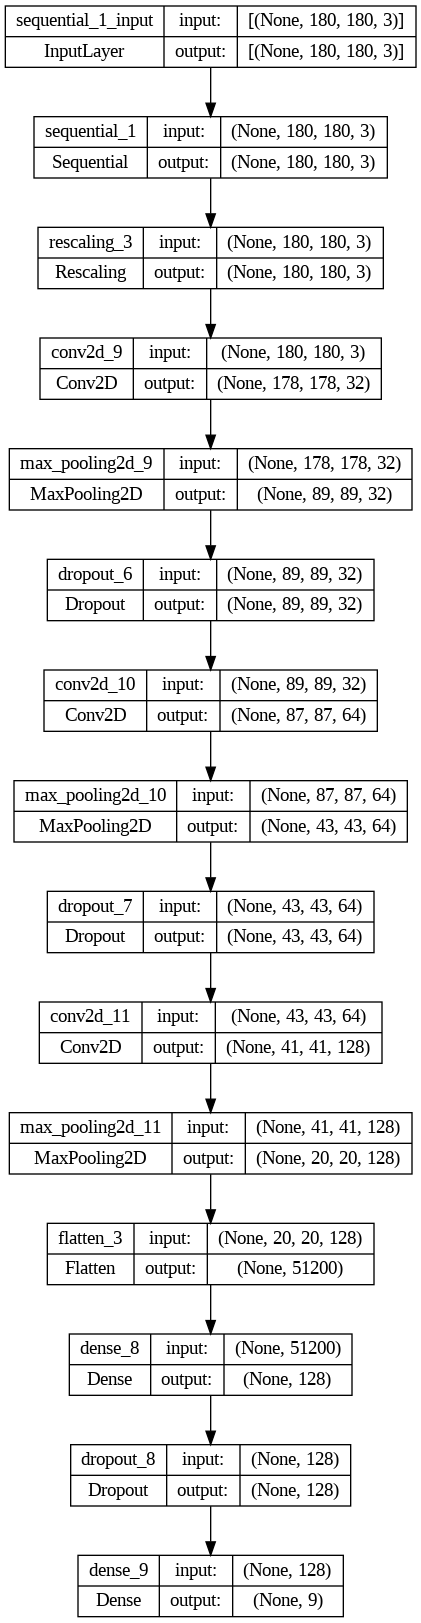

In [51]:
from tensorflow.keras.utils import plot_model
plot_model(model2,to_file='model2_plot.png',show_shapes=True, show_layer_names=True)

In [53]:
## Your code goes here
from tensorflow.keras.callbacks import ReduceLROnPlateau
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)
opt=tf.keras.optimizers.Adam()
model2.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),  # Use categorical crossentropy for multi-class classification
              optimizer=opt,
              metrics=['accuracy'],run_eagerly=True)

### Training the model

In [54]:
## Your code goes here, note: train your model for 20 epochs
epochs=20
history = model2.fit(train_ds,epochs=epochs,validation_data=val_ds)

Epoch 1/20


56/56 [==============================] - 19s 298ms/step - loss: 2.2927 - accuracy: 0.1814 - val_loss: 2.0477 - val_accuracy: 0.1902
Epoch 2/20
56/56 [==============================] - 7s 127ms/step - loss: 1.9585 - accuracy: 0.2606 - val_loss: 1.8194 - val_accuracy: 0.2998
Epoch 3/20
56/56 [==============================] - 7s 117ms/step - loss: 1.8552 - accuracy: 0.3147 - val_loss: 1.7541 - val_accuracy: 0.4273
Epoch 4/20
56/56 [==============================] - 7s 129ms/step - loss: 1.7406 - accuracy: 0.3465 - val_loss: 1.6649 - val_accuracy: 0.4027
Epoch 5/20
56/56 [==============================] - 7s 118ms/step - loss: 1.7121 - accuracy: 0.3795 - val_loss: 1.5938 - val_accuracy: 0.4094
Epoch 6/20
56/56 [==============================] - 7s 117ms/step - loss: 1.6586 - accuracy: 0.3973 - val_loss: 1.6430 - val_accuracy: 0.4049
Epoch 7/20
56/56 [==============================] - 7s 132ms/step - loss: 1.6489 - accuracy: 0.3968 - val_loss: 1.6057 - val_accuracy: 0.4385
Epoch 8/20
56/56

### Visualizing the results

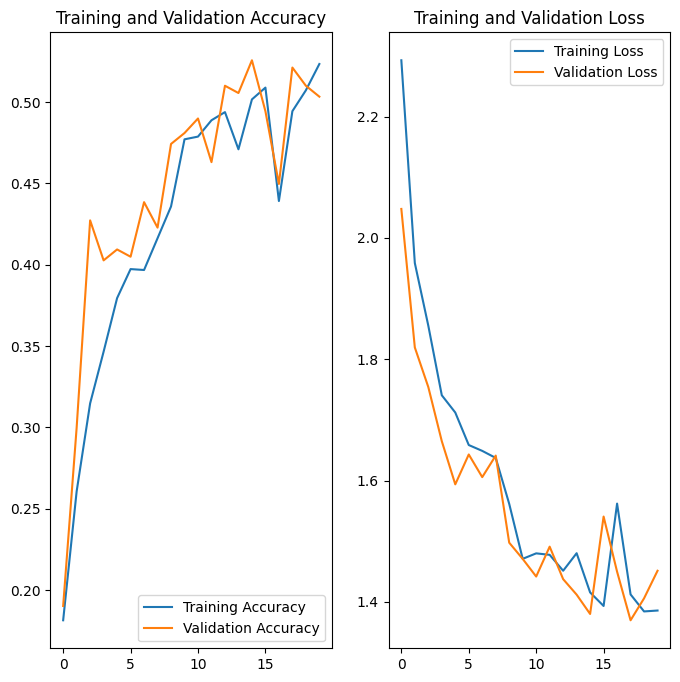

In [55]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [56]:
# @title Class Imbalance Detection
## Your code goes here.
def class_distribution_count(directory):

    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))

    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]

    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,melanoma,438
1,seborrheic keratosis,77
2,actinic keratosis,114
3,squamous cell carcinoma,181
4,dermatofibroma,95
5,vascular lesion,139
6,nevus,357
7,pigmented benign keratosis,462
8,basal cell carcinoma,376


<Axes: xlabel='No. of Image', ylabel='Class'>

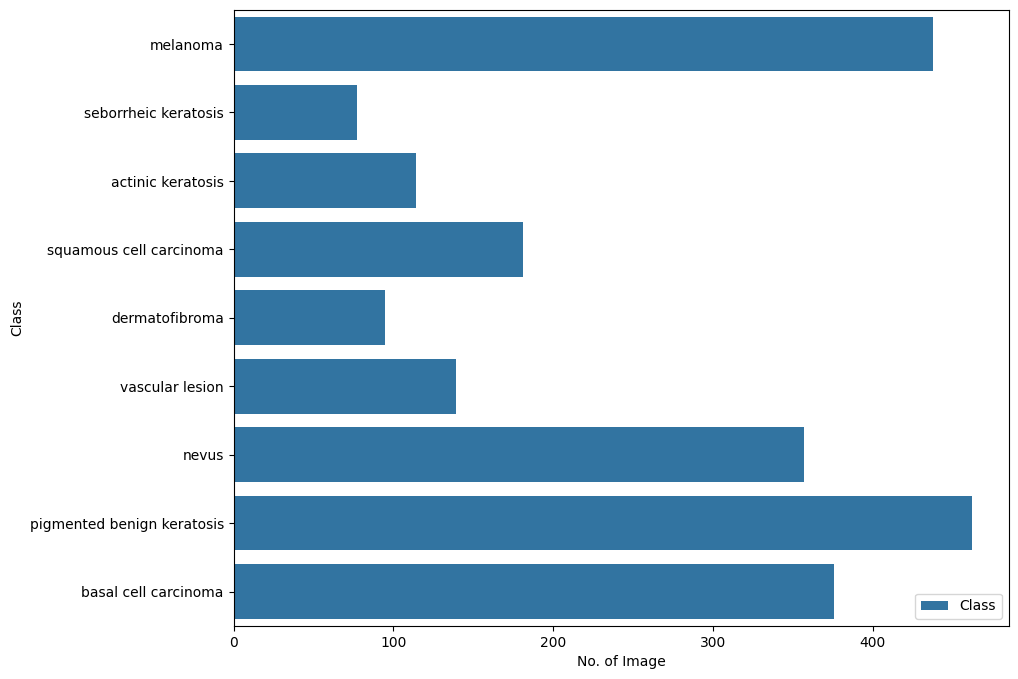

In [57]:
#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")

#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [58]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [59]:
path_to_training_dataset="/content/drive/MyDrive/Colab_Notebooks/SkinCancer_ISIC_Data/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/Colab_Notebooks/SkinCancer_ISIC_Data/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9B785A7AC0>: 100%|██████████| 500/500 [00:21<00:00, 23.16 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/Colab_Notebooks/SkinCancer_ISIC_Data/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F9B785BC580>: 100%|██████████| 500/500 [00:29<00:00, 16.67 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/Colab_Notebooks/SkinCancer_ISIC_Data/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F9B7840B9D0>: 100%|██████████| 500/500 [00:31<00:00, 15.64 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/Colab_Notebooks/SkinCancer_ISIC_Data/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7F9B783F8940>: 100%|██████████| 500/500 [01:31<00:00,  5.46 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/Colab_Notebooks/SkinCancer_ISIC_Data/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9B7844E8C0>: 100%|██████████| 500/500 [01:34<00:00,  5.26 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/Colab_Notebooks/SkinCancer_ISIC_Data/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9B7844B130>: 100%|██████████| 500/500 [00:20<00:00, 24.08 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/Colab_Notebooks/SkinCancer_ISIC_Data/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F9B783F91B0>: 100%|██████████| 500/500 [00:44<00:00, 11.31 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/Colab_Notebooks/SkinCancer_ISIC_Data/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9B7843EC50>: 100%|██████████| 500/500 [00:19<00:00, 25.70 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/Colab_Notebooks/SkinCancer_ISIC_Data/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9B78551360>: 100%|██████████| 500/500 [00:22<00:00, 22.72 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [60]:
import glob
image_count_train = len(glob.glob(data_dir_train + "/**/output/*.jpg"))
print(image_count_train)
#image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
#print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [61]:
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '**','output', '*.jpg'))]
path_list

['/content/drive/MyDrive/Colab_Notebooks/SkinCancer_ISIC_Data/Train/melanoma/output/melanoma_original_ISIC_0010534.jpg_3fcfea3a-ba62-4c1e-a2cc-868bb819ab12.jpg',
 '/content/drive/MyDrive/Colab_Notebooks/SkinCancer_ISIC_Data/Train/melanoma/output/melanoma_original_ISIC_0010532.jpg_cef9b409-eda4-4abc-9967-e11e2937239d.jpg',
 '/content/drive/MyDrive/Colab_Notebooks/SkinCancer_ISIC_Data/Train/melanoma/output/melanoma_original_ISIC_0011185.jpg_b2d57f57-d2c7-4945-95e2-95a1c10e2737.jpg',
 '/content/drive/MyDrive/Colab_Notebooks/SkinCancer_ISIC_Data/Train/melanoma/output/melanoma_original_ISIC_0010900.jpg_5b027c47-0bda-42c5-86b2-bbd55d6abb1f.jpg',
 '/content/drive/MyDrive/Colab_Notebooks/SkinCancer_ISIC_Data/Train/melanoma/output/melanoma_original_ISIC_0011112.jpg_1b315ae0-ee9a-4988-8598-231e7a96b460.jpg',
 '/content/drive/MyDrive/Colab_Notebooks/SkinCancer_ISIC_Data/Train/melanoma/output/melanoma_original_ISIC_0000165.jpg_d0393b41-108e-466b-b71f-f8e990e1af58.jpg',
 '/content/drive/MyDrive/Col

In [62]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '**','output', '*.jpg'))]
lesion_list_new

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [63]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [64]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
#new_df = original_df.append(df2)

In [65]:
new_df=df2

In [66]:
new_df['Label'].value_counts()

Label
melanoma                      500
seborrheic keratosis          500
actinic keratosis             500
squamous cell carcinoma       500
dermatofibroma                500
vascular lesion               500
nevus                         500
pigmented benign keratosis    500
basal cell carcinoma          500
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [67]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [68]:
data_dir_train="/content/drive/MyDrive/Colab_Notebooks/SkinCancer_ISIC_Data/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
validation_split = 0.2,
subset = "training",  # Choose the correct parameter value to refer only to training data
image_size =(img_height, img_width),
label_mode='categorical',
batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [69]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  label_mode='categorical',
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [71]:
## your code goes here
#Model

model3 = Sequential()


model2.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=input_shape))
#First Convulation layer
model3.add(layers.Conv2D(32,kernel_size=(2,2),activation='relu'))
model3.add(layers.MaxPool2D(pool_size=(2,2)))
model3.add(layers.Dropout(0.25))

#Second Convulation Layer
model3.add(layers.Conv2D(64,kernel_size=(2,2),activation='relu'))
model3.add(layers.MaxPool2D(pool_size=(2,2)))
model3.add(layers.Dropout(0.25))

#Third Convulation Layer
model3.add(layers.Conv2D(128,kernel_size=(2,2),activation='relu'))
model3.add(layers.MaxPool2D(pool_size=(2,2)))

#Flatten Layer
model3.add(layers.Flatten())

#Dense Layer
#model3.add(layers.Dense(512,activation='relu'))



#Batch normalization: is a method used to make artificial neural networks faster and more stable through normalization
#of the layers' inputs by re-centering and re-scaling.
model3.add(layers.BatchNormalization())

#Dense Layer
model3.add(layers.Dense(128,activation='relu'))

#Dropout layer with 50% Fraction of the input units to drop.
model3.add(layers.Dropout(0.50))



#Dense layer with Softmax activation function.
model3.add(layers.Dense(len(class_names),activation='softmax'))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [88]:
opt=tf.keras.optimizers.Adam()
model3.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),  # Use categorical crossentropy for multi-class classification
              optimizer=opt,
              metrics=['accuracy'],run_eagerly=True)

In [91]:
## your code goes here
model3.compile(optimizer='adam',
              loss="CategoricalCrossentropy",
              metrics=['accuracy'])

In [92]:
model3.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 179, 179, 32)      416       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 89, 89, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_9 (Dropout)         (None, 89, 89, 32)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 88, 88, 64)        8256      
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 44, 44, 64)        0         
 ng2D)                                                           
                                                                 
 dropout_10 (Dropout)        (None, 44, 44, 64)       

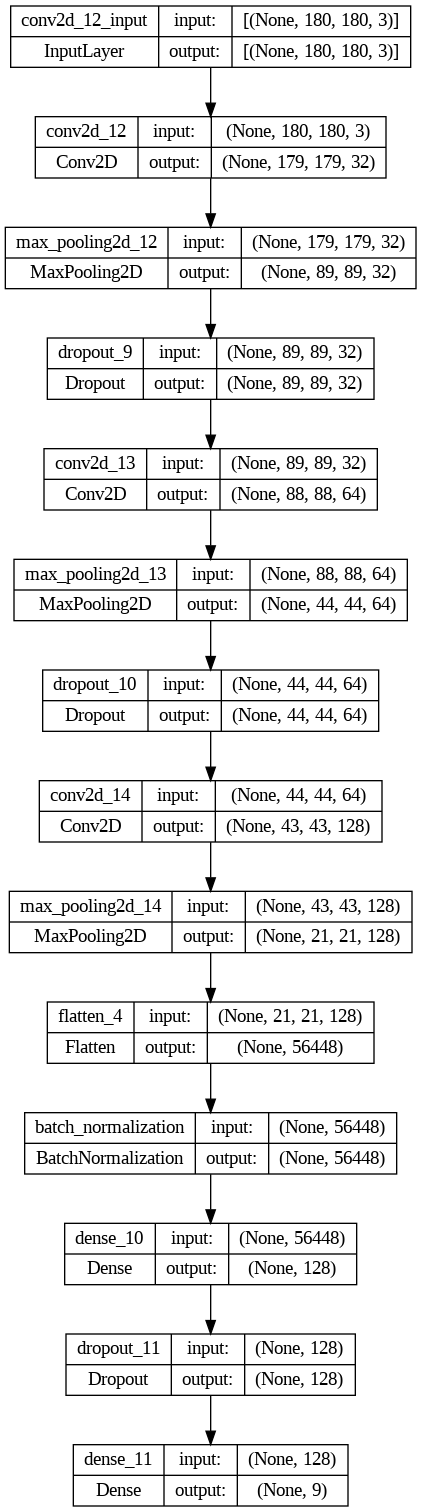

In [93]:
from tensorflow.keras.utils import plot_model
plot_model(model3,to_file='model3_plot.png',show_shapes=True, show_layer_names=True)

#### **Todo:**  Train your model

In [94]:

epochs = 30
labels = tf.reshape(labels, (-1, 1))
## Your code goes here, use 30 epochs.
history = model3.fit(train_ds,epochs=epochs,validation_data=val_ds)

Epoch 1/30
169/169 [==============================] - 49s 266ms/step - loss: 2.7730 - accuracy: 0.2072 - val_loss: 18.3585 - val_accuracy: 0.1359
Epoch 2/30
169/169 [==============================] - 48s 274ms/step - loss: 1.8717 - accuracy: 0.2932 - val_loss: 19.0455 - val_accuracy: 0.2146
Epoch 3/30
169/169 [==============================] - 46s 266ms/step - loss: 1.7660 - accuracy: 0.3392 - val_loss: 27.3577 - val_accuracy: 0.1336
Epoch 4/30
169/169 [==============================] - 46s 262ms/step - loss: 1.6939 - accuracy: 0.3591 - val_loss: 29.0063 - val_accuracy: 0.1656
Epoch 5/30
169/169 [==============================] - 46s 264ms/step - loss: 1.6716 - accuracy: 0.3739 - val_loss: 32.0742 - val_accuracy: 0.1359
Epoch 6/30
169/169 [==============================] - 45s 261ms/step - loss: 1.6372 - accuracy: 0.3772 - val_loss: 29.2964 - val_accuracy: 0.1396
Epoch 7/30
169/169 [==============================] - 48s 273ms/step - loss: 1.6084 - accuracy: 0.3917 - val_loss: 13.1434 -

#### **Todo:**  Visualize the model results

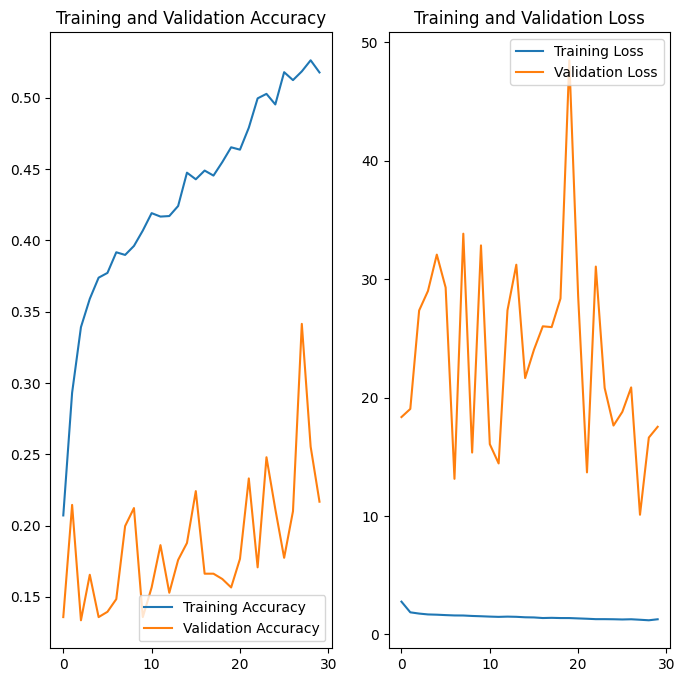

In [95]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

